In [103]:
import os
import gc
import sys
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from glob import glob
from tqdm import tqdm
from datetime import datetime, date
from collections import defaultdict, Counter
from multiprocessing import cpu_count, Pool

import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler, minmax_scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

import lightgbm as lgb

import warning
warnings.simplefilter('ignore')

In [26]:
PATH = os.path.join('..', 'data')

KEY = 'card_id'

SEED = 18
# SEED = np.random.randint(9999)

NTHREAD = cpu_count()

NFOLD = 4

In [40]:
tf.set_random_seed(1)
np.random.seed(1)
random.seed(1) 

In [123]:
df = pd.read_csv(os.path.join(PATH, 'train.csv'))
# train = pd.read_csv(os.path.join(PATH, 'train.csv'))
test = pd.read_csv(os.path.join(PATH, 'test.csv'))
# df = pd.concat([train, test], axis=0)
# del train, test
# gc.collect()

In [96]:
df.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,mean_feature_1,mean_feature_2,mean_feature_3,first_active_month_year,first_active_month_weekday,first_active_month_month,first_active_month_weekofyear,first_active_month_quarter,first_active_month_is_month_start,elapsed_time,elapsed_time_feature_1,elapsed_time_feature_2,elapsed_time_feature_3
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283,0.013145,0.008752,0.011428,2017,3,6,22,2,1,245,1225,490,245
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913,0.010712,0.011385,0.010283,2017,6,1,52,1,1,396,1584,396,0
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056,0.010610,0.008752,0.010283,2016,0,8,31,3,1,549,1098,1098,0
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495,0.010712,0.014166,0.010283,2017,4,9,35,3,1,153,612,459,0
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749,0.008058,0.014166,0.010283,2017,2,11,44,4,1,92,92,276,0


In [97]:
df = df[df.target > -30]

In [98]:
df[['elapsed_time_feature_1', 'elapsed_time_feature_2', 'elapsed_time_feature_3']].nunique()

elapsed_time_feature_1    224
elapsed_time_feature_2    177
elapsed_time_feature_3     75
dtype: int64

In [99]:
for c in df.columns: 
    print(c, df[c].max(), df[c].min())

first_active_month 2018-02-01 2011-11-01
card_id C_ID_fffffd5772 C_ID_00007093c1
feature_1 5 1
feature_2 3 1
feature_3 1 0
target 17.965068399999996 -17.60814651
mean_feature_1 0.013144615384615385 0.008058486333804104
mean_feature_2 0.014166402368115024 0.008752121220219405
mean_feature_3 0.011427520622077443 0.01028283496163887
first_active_month_year 2018 2011
first_active_month_weekday 6 0
first_active_month_month 12 1
first_active_month_weekofyear 53 1
first_active_month_quarter 4 1
first_active_month_is_month_start 1 1
elapsed_time 2284 0
elapsed_time_feature_1 7765 0
elapsed_time_feature_2 6852 0
elapsed_time_feature_3 2284 0


In [122]:
hidden_units = (16, 32, 4)
elapsed_time_feature_1_embedding_size = 4
elapsed_time_feature_2_embedding_size = 4
elapsed_time_feature_3_embedding_size = 4

# Each instance will consist of two inputs: a single user id, and a single movie id
elapsed_time_feature_1_input = keras.Input(shape=(1,), name='elapsed_time_feature_1')
elapsed_time_feature_2_input = keras.Input(shape=(1,), name='elapsed_time_feature_2')
elapsed_time_feature_3_input = keras.Input(shape=(1,), name='elapsed_time_feature_3')

elapsed_time_feature_1_embedded = keras.layers.Embedding(
    df.elapsed_time_feature_1.max()+1, 
    elapsed_time_feature_1_embedding_size,
    input_length=1,
    name='elapsed_time_feature_1_embedded')(elapsed_time_feature_1_input)

elapsed_time_feature_2_embedded = keras.layers.Embedding(
    df.elapsed_time_feature_2.max()+1, 
    elapsed_time_feature_2_embedding_size,
    input_length=1,
    name='elapsed_time_feature_2_embedded')(elapsed_time_feature_2_input)

elapsed_time_feature_3_embedded = keras.layers.Embedding(
    df.elapsed_time_feature_3.max()+1, 
    elapsed_time_feature_3_embedding_size,
    input_length=1,
    name='elapsed_time_feature_3_embedded')(elapsed_time_feature_3_input)

concatenated = keras.layers.Concatenate()(
    [elapsed_time_feature_1_embedded, elapsed_time_feature_2_embedded, elapsed_time_feature_3_embedded])
# dotted = keras.layers.Dot(3)([
#     elapsed_time_feature_1_embedded, elapsed_time_feature_2_embedded, elapsed_time_feature_3_embedded
# ])
out = keras.layers.Flatten()(concatenated)

for n_hidden in hidden_units:
    out = keras.layers.Dense(n_hidden, activation='relu')(out)
    out = keras.layers.BatchNormalization()(out)
    out = keras.layers.LeakyReLU(alpha=.001)(out)

out = keras.layers.Dropout(0.2)(out)
out = keras.layers.Dense(1, activation='linear', name='prediction')(out)

model = keras.Model(
    inputs = [elapsed_time_feature_1_input, elapsed_time_feature_2_input, elapsed_time_feature_3_input],
    outputs = out,
)
model.summary(line_length=88)

________________________________________________________________________________________
Layer (type)                 Output Shape       Param #   Connected to                  
elapsed_time_feature_1 (Inpu (None, 1)          0                                       
________________________________________________________________________________________
elapsed_time_feature_2 (Inpu (None, 1)          0                                       
________________________________________________________________________________________
elapsed_time_feature_3 (Inpu (None, 1)          0                                       
________________________________________________________________________________________
elapsed_time_feature_1_embed (None, 1, 4)       31064     elapsed_time_feature_1[0][0]  
________________________________________________________________________________________
elapsed_time_feature_2_embed (None, 1, 4)       27412     elapsed_time_feature_2[0][0]  
_____________________

In [115]:
y = (df.target - df.target.mean()) / df.target.std()

In [116]:
model.compile(
    tf.train.AdamOptimizer(0.005),
    loss='MSE',
    metrics=['MAE'],
)

history = model.fit(
    [df.elapsed_time_feature_1, 
     df.elapsed_time_feature_2,
     df.elapsed_time_feature_3],
    y,
    batch_size=64,
    epochs=10,
    verbose=100,
    validation_split=0.2,
)

Train on 159768 samples, validate on 39942 samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10


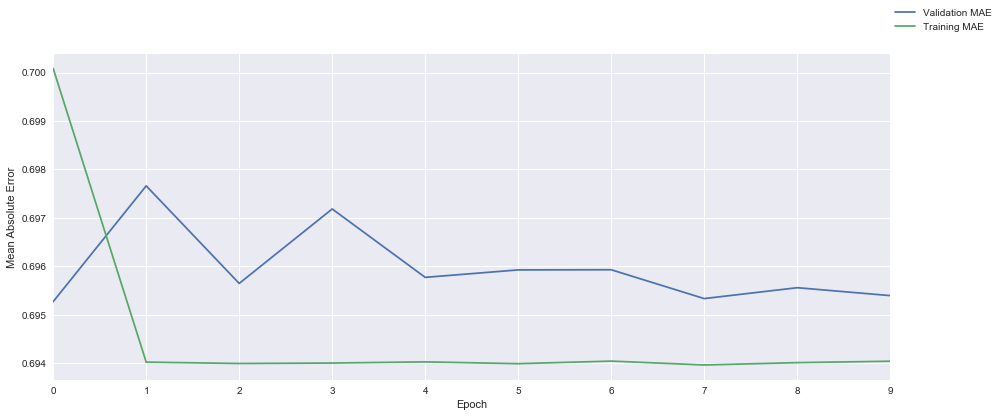

In [117]:
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(history.epoch, history.history['val_mean_absolute_error'], label='Validation MAE')
ax.plot(history.epoch, history.history['mean_absolute_error'], label='Training MAE')
ax.set_xlabel('Epoch')
ax.set_ylabel('Mean Absolute Error')
ax.set_xlim(left=0, right=history.epoch[-1])
# baseline_mae = 0
# ax.axhline(baseline_mae, ls='--', label='Baseline', color='#002255', alpha=.5)
ax.grid(True)
fig.legend();

In [128]:
df.first_active_month.max()

'2018-02-01'

In [127]:
test.first_active_month.max()

'2018-01-01'